In [1]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Jingqi\Documents\GitHub\30DayMapChallenge\_data\map7_luciano\foodbank.csv")
df.head()


,name,address
0,La Villita Corps Community Center,"3621 W 24th St, Chicago, IL 60623"
1,Garfield Park Community Worship Center,"4100 W Jackson Blvd, Chicago, IL 60624"
2,Fellowship MBC,"4543 S Princeton, Chicago, IL 60609"
3,Program Phone 773-924-3232,"3823 S Indiana Ave, Chicago, IL 60653"
4,Our Lady of Tepeyac Parish,"3047 W Cermak Rd, Chicago, IL 60623"


In [3]:
geolocator = Nominatim(user_agent="foodbank_locator")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) 

latitudes, longitudes = [], []
for addr in df["address"]:
    try:
        location = geocode(addr)
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except Exception as e:
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)

df["latitude"] = latitudes
df["longitude"] = longitudes

df.to_csv("foodbank_geocoded.csv", index=False)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf.to_file("foodbank_points.geojson", driver="GeoJSON")

print("complete：")
print("foodbank_geocoded.csv")
print("foodbank_points.geojson")

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1111 N Wells St Ste 500, Chicago, IL 60610',), **{}).
Traceback (most recent call last):
  File "c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\urllib3\connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\http\client.py", line 1430, in getresponse
    response.begin()
    ~~~~~~~~~~~~~~^^
  File "c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\http\client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ~~~~~~~~~~~~~~~~~^^
  File "c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\http\client.py", line 292, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ~~~~~~~~~~~~~~~~^^^^^^^

complete：
foodbank_geocoded.csv
foodbank_points.geojson


In [4]:
import osmnx as ox
import geopandas as gpd

city = ox.geocode_to_gdf("Chicago, Illinois, USA")
print(city.head())


                                            geometry  bbox_west  bbox_south  \
0  POLYGON ((-87.94009 42.0008, -87.94003 41.9981... -87.940088   41.644531   

   bbox_east  bbox_north   place_id  osm_type  osm_id        lat        lon  \
0 -87.524081    42.02304  341243343  relation  122604  41.875562 -87.624421   

      class            type  place_rank  importance addresstype     name  \
0  boundary  administrative          16    0.802726        city  Chicago   

                                        display_name  
0  Chicago, South Chicago Township, Cook County, ...  


In [66]:
import osmnx as ox
import geopandas as gpd

G = ox.graph_from_place("Chicago, Illinois, USA", network_type="drive")

roads = ox.graph_to_gdfs(G, nodes=False, edges=True)

major_roads = roads[roads["highway"].isin(["trunk", "primary", "secondary"])]

major_roads.to_file("chicago_major_roads.geojson", driver="GeoJSON")

print(f"access {len(major_roads)} main roads")
print(major_roads[["highway", "name"]].head())


access 16564 main roads
                          highway  \
u        v         key              
26098097 705003083 0        trunk   
26098103 704695482 0        trunk   
26098113 739120275 0    secondary   
         739118620 0        trunk   
26099529 258964877 0    secondary   

                                                                     name  
u        v         key                                                     
26098097 705003083 0                       South DuSable Lake Shore Drive  
26098103 704695482 0                       South DuSable Lake Shore Drive  
26098113 739120275 0                                    East Monroe Drive  
         739118620 0    South Jean Baptiste Point DuSable Lake Shore D...  
26099529 258964877 0                               West Fullerton Parkway  


In [67]:
import geopandas as gpd

roads = gpd.read_file("chicago_major_roads.geojson").to_crs(epsg=3857)
food  = gpd.read_file("foodbank_points.geojson").to_crs(epsg=3857)

roads.head(), food.head(), roads.crs, food.crs


Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5


(          u          v  key                                osmid    highway  \
 0  26098097  705003083    0             [ 80874394, 1000805423 ]      trunk   
 1  26098103  704695482    0             [ 902555112, 518376771 ]      trunk   
 2  26098113  739120275    0                           1171998660  secondary   
 3  26098113  739118620    0            [ 1087177611, 316916062 ]      trunk   
 4  26099529  258964877    0  [ 435545080, 373857674, 435545079 ]  secondary   
 
    oneway reversed      length    ref access tunnel width junction  area  \
 0    True    False  366.191227  US 41   None   None  None     None  None   
 1    True    False  110.535578  US 41   None   None  None     None  None   
 2   False     True   21.704135   None   None   None  None     None  None   
 3    True    False  241.493631  US 41   None   None  None     None  None   
 4   False     True  201.435381   None   None   None  None     None  None   
 
                                             geometry 

In [68]:
fb_buf = food[["geometry"]].copy()
fb_buf["geometry"] = fb_buf.buffer(1000)  
fb_union = fb_buf.unary_union             
len(fb_buf), fb_buf.geometry.iloc[0].geom_type


C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\2881503653.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fb_union = fb_buf.unary_union


(63, 'Polygon')

In [69]:
roads = roads.reset_index(drop=False).rename(columns={"index":"road_id"})
roads = roads.loc[:, ~roads.columns.duplicated()]
roads.columns.tolist()[:6]

['road_id', 'u', 'v', 'key', 'osmid', 'highway']

In [70]:

hit = gpd.sjoin(roads[["road_id", "geometry"]], fb_buf[["geometry"]],
                how="left", predicate="intersects")

hit = hit.loc[:, ~hit.columns.duplicated()]

hits_per_road = (
    hit["road_id"]
    .value_counts()
    .rename_axis("road_id")
    .reset_index(name="fb_buf_hits")
)

roads = roads.merge(hits_per_road, on="road_id", how="left")
roads["fb_buf_hits"] = roads["fb_buf_hits"].fillna(0).astype(int)

roads[["road_id", "fb_buf_hits"]].head()



,road_id,fb_buf_hits
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [82]:
def classify(n):
    if n == 0:
        return "outside_500m"
    if n == 1:
        return "within_500m_one"
    return "within_500m_multi"

roads["fb_class"] = roads["fb_buf_hits"].apply(classify)
roads = roads.loc[:, ~roads.columns.duplicated()]



In [83]:
roads["length_m"] = roads.geometry.length
roads_long = roads[roads["length_m"] >= 0].copy()
len(roads), len(roads_long)


(16564, 16564)

In [84]:
roads_long["fb_class"].value_counts()
roads_long["fb_buf_hits"].value_counts().sort_index()


fb_buf_hits
1    15384
2      767
3      301
4       84
5       16
6       12
Name: count, dtype: int64

C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\284699138.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


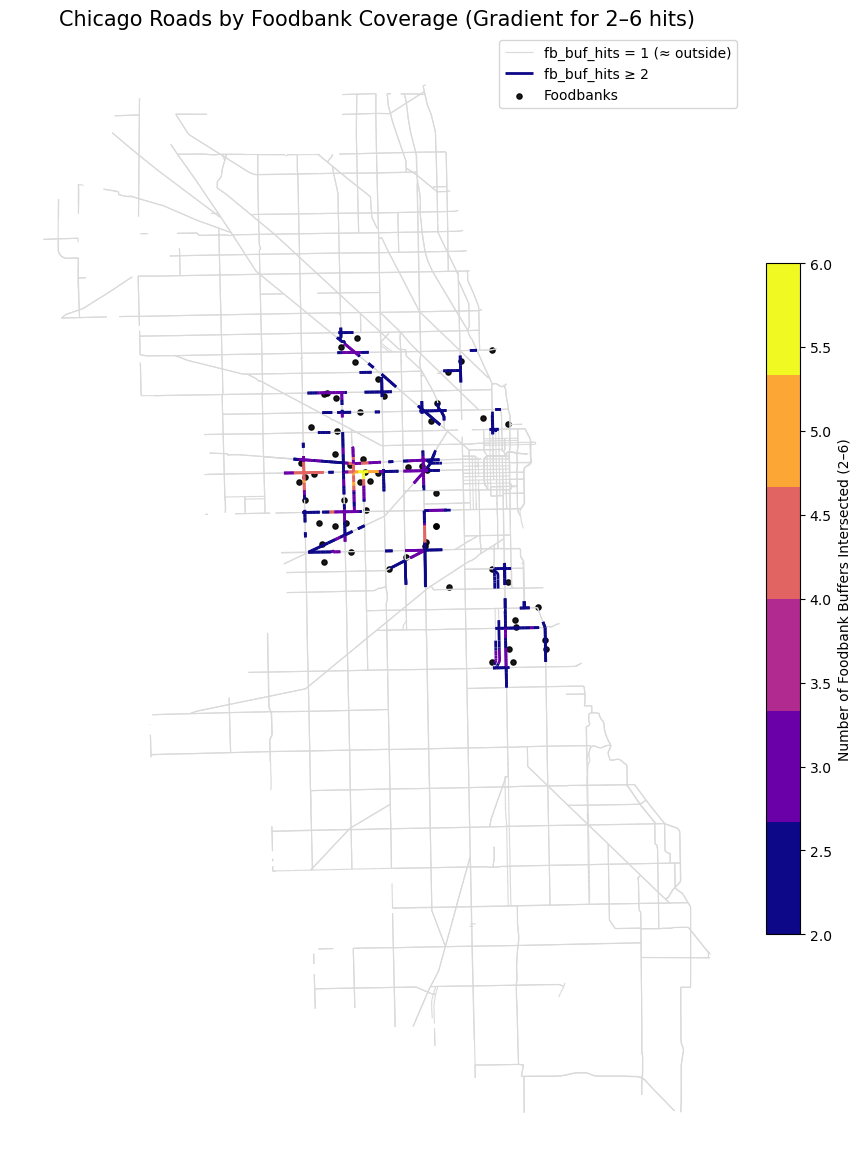

In [85]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.get_cmap('plasma', 6) 
norm = mcolors.Normalize(vmin=2, vmax=6)

fig, ax = plt.subplots(figsize=(12, 12))

roads_long[roads_long["fb_buf_hits"] == 1].plot(
    ax=ax, color="#D9D9D9", linewidth=0.8, label="fb_buf_hits = 1 (≈ outside)"
)

subset = roads_long[roads_long["fb_buf_hits"] >= 2]
subset.plot(
    ax=ax,
    column="fb_buf_hits",
    cmap=cmap,
    norm=norm,
    linewidth=2.0,
    label="fb_buf_hits ≥ 2"
)

food.plot(ax=ax, color="black", markersize=14, alpha=0.9, label="Foodbanks")

plt.title("Chicago Roads by Foodbank Coverage (Gradient for 2–6 hits)", fontsize=15)
plt.axis("off")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Number of Foodbank Buffers Intersected (2–6)")

plt.legend(frameon=True)
plt.tight_layout()
plt.show()



C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\3616847757.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = buffers_500m.unary_union  # 合并所有食物银行的范围
C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\3616847757.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


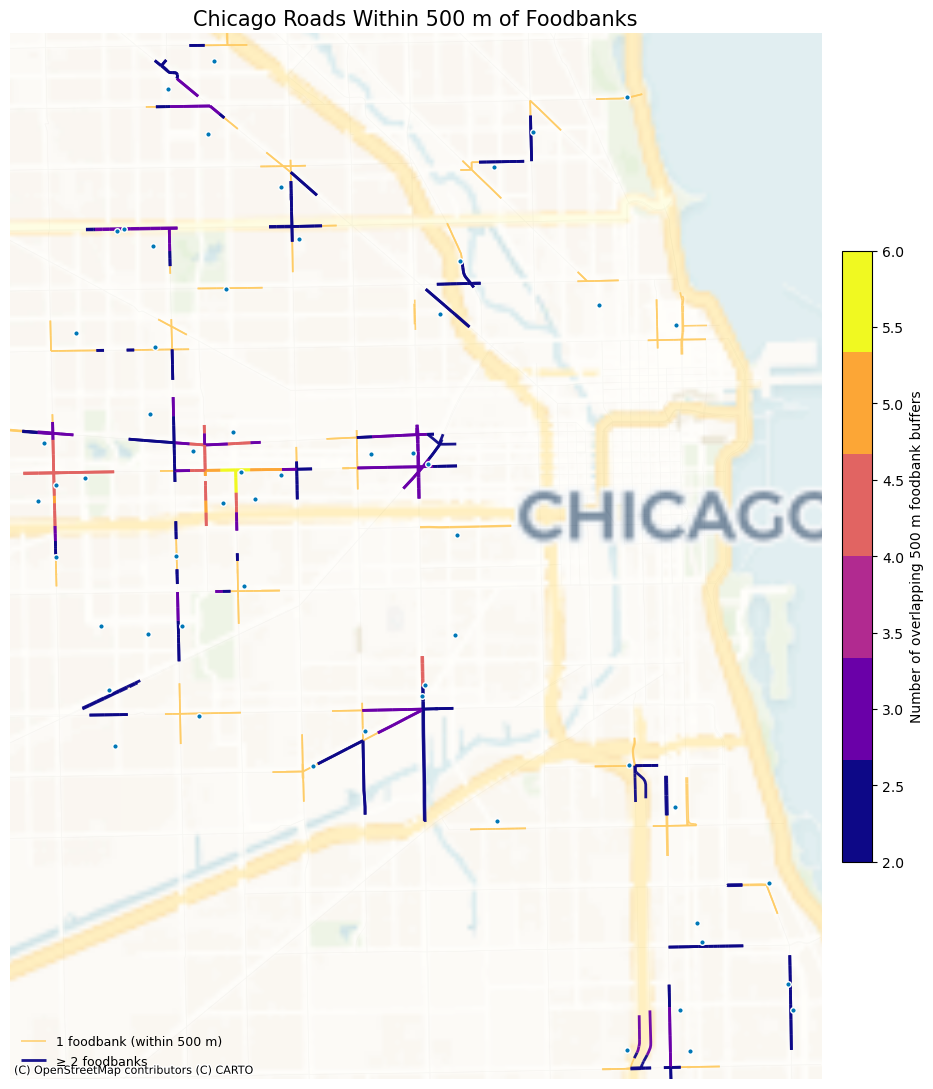

In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# --- 1. 准备 buffer 区域 ---
food_3857 = food.to_crs(3857)
buffers_500m = food_3857.buffer(500)
buffer_union = buffers_500m.unary_union  # 合并所有食物银行的范围

# --- 2. 只保留 buffer 区域内的道路 ---
roads_in = roads_long[roads_long.intersects(buffer_union)].copy()

# --- 3. 定义配色 ---
cmap = cm.get_cmap('plasma', 6)
norm = mcolors.Normalize(vmin=2, vmax=6)

fig, ax = plt.subplots(figsize=(11, 11))

# 灰底道路（仅可选）
roads_long.plot(ax=ax, color="#eaeaea", linewidth=0.4, zorder=0)

# 单一覆盖的路段（1 foodbank）
roads_in[roads_in["fb_buf_hits"] == 1].plot(
    ax=ax,
    color="#ffcc66",
    linewidth=1.2,
    alpha=0.9,
    zorder=1,
    label="1 foodbank (within 500 m)"
)

# 多重覆盖的路段（2+ foodbanks）
roads_in[roads_in["fb_buf_hits"] >= 2].plot(
    ax=ax,
    column="fb_buf_hits",
    cmap=cmap,
    norm=norm,
    linewidth=2.0,
    alpha=0.95,
    zorder=2,
    label="≥ 2 foodbanks"
)

# --- 4. Foodbanks ---
food_3857.plot(ax=ax, color="#0077b6", markersize=16, edgecolor="white", zorder=3)

# --- 5. 加底图 ---
ctx.add_basemap(
    ax,
    crs=roads_in.crs,
    source=ctx.providers.CartoDB.Voyager,
    alpha=0.7,    # 稍微半透明一点
    zorder=0
)

# --- 6. 调整范围（仅聚焦有 buffer 的区域） ---
minx, miny, maxx, maxy = buffer_union.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- 7. 图例与标题 ---
plt.title("Chicago Roads Within 500 m of Foodbanks", fontsize=15)
plt.axis("off")
plt.legend(frameon=False, fontsize=9, loc="lower left")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Number of overlapping 500 m foodbank buffers", fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\3455248034.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 7)  # 7 个阶梯色（0–6）
C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\3455248034.py:17: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  roads_long[roads_long["fb_buf_hits"] == 0].plot(
C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\3455248034.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  focus = food.to_crs(roads_long.crs).unary_union.buffer(4000)  # 原 5000 → 4000


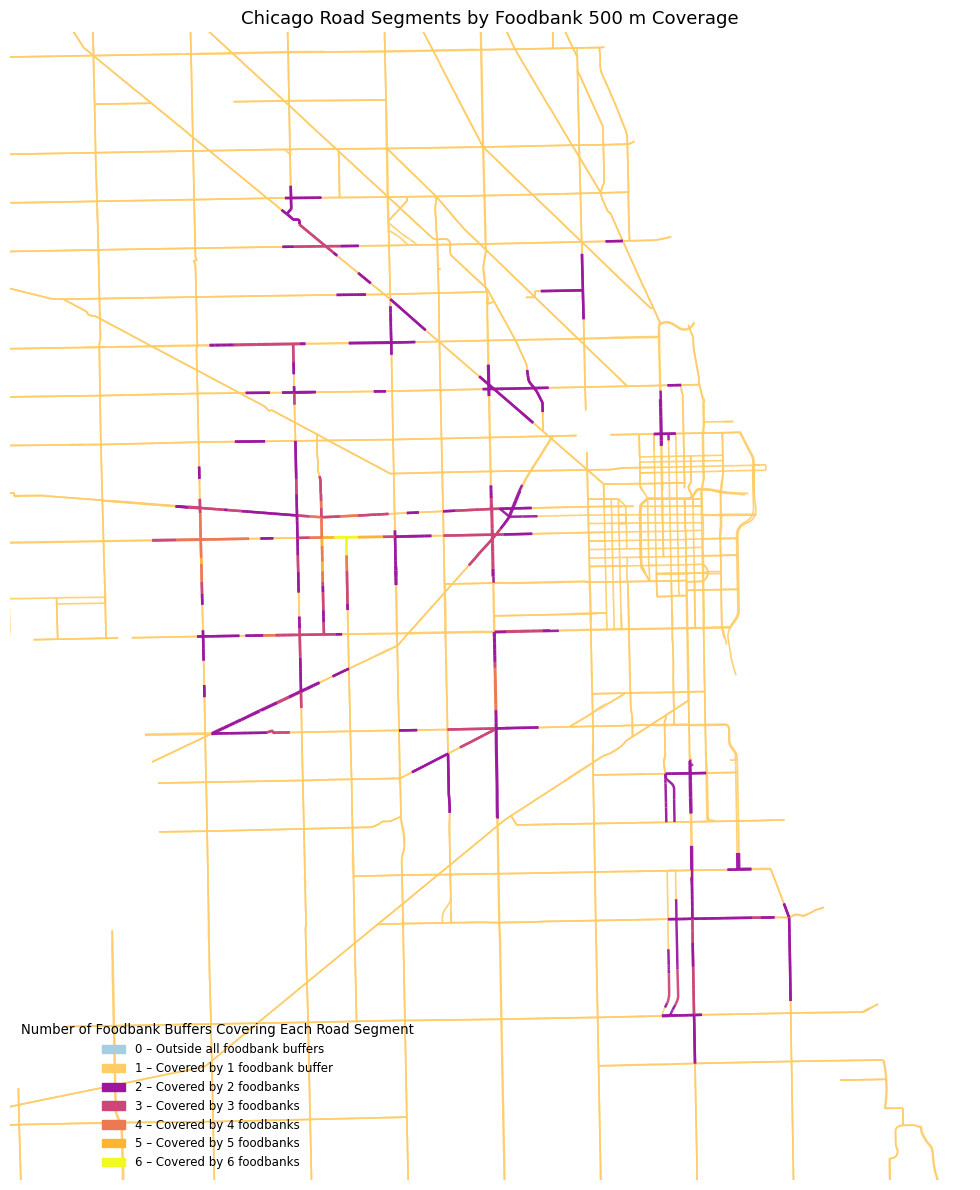

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# === colormap & normalization ===
# 这里我们让颜色从 0 开始（包含 outside）
cmap = cm.get_cmap('plasma', 7)  # 7 个阶梯色（0–6）
norm = mcolors.Normalize(vmin=0, vmax=6)

# --- figure size ---
fig, ax = plt.subplots(figsize=(12, 12))

# --- 0️⃣ roads outside all buffers (0 foodbanks) ---
roads_long[roads_long["fb_buf_hits"] == 0].plot(
    ax=ax,
    color="#a6cee3",      # 柔蓝色（不显眼但有存在感）
    linewidth=0.6,
    alpha=0.8,
    zorder=0
)

# --- 1️⃣ within one foodbank buffer ---
roads_long[roads_long["fb_buf_hits"] == 1].plot(
    ax=ax,
    color="#ffcc66",
    linewidth=1.2,
    alpha=0.9,
    zorder=1
)

# --- 2️⃣ within multiple foodbank buffers ---
subset = roads_long[roads_long["fb_buf_hits"] >= 2]
subset.plot(
    ax=ax,
    column="fb_buf_hits",
    cmap=cmap,
    norm=norm,
    linewidth=1.8,
    alpha=0.95,
    zorder=2
)


# --- extent: 稍微缩小一点视野 ---
focus = food.to_crs(roads_long.crs).unary_union.buffer(4000)  # 原 5000 → 4000
minx, miny, maxx, maxy = focus.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- title ---
plt.title("Chicago Road Segments by Foodbank 500 m Coverage", fontsize=13)
plt.axis("off")

# --- legend ---
legend_elements = [
    mpatches.Patch(color="#a6cee3", label="0 – Outside all foodbank buffers"),
    mpatches.Patch(color="#ffcc66", label="1 – Covered by 1 foodbank buffer"),
]
for i in range(2, 7):
    legend_elements.append(
        mpatches.Patch(color=cmap(norm(i)), label=f"{i} – Covered by {i} foodbanks")
    )

plt.legend(
    handles=legend_elements,
    title="Number of Foodbank Buffers Covering Each Road Segment",
    frameon=False,
    fontsize=8.5,
    title_fontsize=9.5,
    loc="lower left"
)

plt.tight_layout()
plt.show()



In [105]:
roads_long.to_file("roads_foodbank_hits.shp", driver="ESRI Shapefile")


C:\Users\Jingqi\AppData\Local\Temp\ipykernel_2268\4077181732.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  roads_long.to_file("roads_foodbank_hits.shp", driver="ESRI Shapefile")
c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fb_buf_hits' to 'fb_buf_hit'
  ogr_write(
c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fb_buf_hits_500' to 'fb_buf_h_1'
  ogr_write(


In [106]:
print(roads_long.crs)


EPSG:3857


In [108]:
import geopandas as gpd

# 1️⃣ 拷贝点数据
food_export = food.copy()

# 2️⃣ 删除 geometry 缺失的行（防止导出错误）
food_export = food_export[food_export.geometry.notnull()]

# 3️⃣ 统一 CRS 为 WGS84 (EPSG:4326)
food_export = food_export.to_crs(epsg=4326)

# 4️⃣ 只保留关键字段
food_export = food_export.loc[:, ["name", "address", "geometry"]]

# 5️⃣ 导出为 Shapefile
food_path = "foodbanks_points.shp"
food_export.to_file(food_path, driver="ESRI Shapefile")

print(f"✅ 已成功导出 Shapefile：{food_path}")
print(f"共 {len(food_export)} 个点。")


✅ 已成功导出 Shapefile：foodbanks_points.shp
共 59 个点。
